# Visualization DataFrame Creation
This notebook is dedicated to the creation of a pandas DataFrame to be used for the visualization of the RAIS dataset. The data will be presented on a per-user and per-day basis (daily granularity). The dataframe includes all collected data types, such as Fitbit data, SEMA data, and surveys data.

In [390]:
import os
import warnings

import matplotlib.pyplot as plt
import pickle
import gc
import numpy as np
import swifter
import pickle
import seaborn as sns
import pandas as pd
from datetime import datetime
import matplotlib.ticker as mticker
import matplotlib.dates as md
from tqdm import tqdm
from pymongo import MongoClient
from datetime import datetime
import json
from datetime import date
from bson import ObjectId

from definitions import ROOT_DIR

## Setting Current Working Directory
Changing CWD to root

In [391]:
os.chdir(ROOT_DIR)

In [392]:
ROOT_DIR

'C:\\Users\\Sofia\\PycharmProjects\\RAIS-EDA'

## Connecting to MongoDB

In [393]:
with open('credentials.json') as f:
    data = json.load(f)
    username = data['username']
    password = data['password']

# Connection to raisv2 database
client = MongoClient('mongodb://%s:%s@127.0.0.1' % (username, password))
db = client.raisV3_anonymized

In [394]:
users = db.fitbit.distinct('id')

## Integrating Fitbit Data
Fitbit includes a variety of information, such as physical activity, sleep, and stress patterns, as well data about SpO2, EDA, VO2 max, etc., at different granularities. Here we read each data type and integrate it into our visualization DataFrame with daily granularity.

### Computed Temperature
The night skin temperature of the user during sleep (N=4332). Not applicable at hourly granularity.

### Daily Heart Rate Variability Summary
The heart rate variability of the user (N=2891).  Not applicable at hourly granularity.

### Daily SpO2
Daily oxygen saturation levels of the user (N=1606).  Not applicable at hourly granularity.

### Respiratory Rate Summary
Data about sleep breathing (N=3517).  Not applicable at hourly granularity.

### Stress Score
Fitbit Sense users see a daily Stress Management Score (N=2578) in the Fitbit app ranging from 1 to 100 - where a higher number means you’re showing fewer physical signs of stress. It’s calculated based on three metrics: your Responsiveness (score out of 30), Exertion Balance (score out of 40) and Sleep Patterns (score out of 30).  Not applicable at hourly granularity.

### Wrist Temperature
Data about the skin temperature of the user during the day (N=5,217,923). The value refers to the difference between the measured value and the user’s 30-day baseline (unknown where the baseline is stored or how it is calculated). The data are stored at a 3-minute granularity.

In [395]:
users_wrist_temperature = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "Wrist Temperature"},
            {"id": user}
        ]},
            {"id": 1, "data.recorded_time": 1, "data.temperature": 1, "_id": 0}
        )
    ))

    users_wrist_temperature = pd.concat([users_wrist_temperature, user_data], axis=0)

# split data column (json format) into two columns
users_wrist_temperature["date"] = users_wrist_temperature["data"].swifter.apply(lambda d: d["recorded_time"])
users_wrist_temperature["temperature"] = users_wrist_temperature["data"].swifter.apply(lambda d: d["temperature"])
users_wrist_temperature.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_wrist_temperature["date"] = pd.to_datetime(users_wrist_temperature["date"], infer_datetime_format=True)
users_wrist_temperature["hour"] = users_wrist_temperature["date"].dt.hour
users_wrist_temperature["date"] = pd.to_datetime(users_wrist_temperature["date"].dt.date, infer_datetime_format=True)

C:\ProgramData\Anaconda3\envs\RAIS-Data-Analysis\lib\site-packages\swifter\swifter.py:35: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4372238 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4372238 [00:00<?, ?it/s]

<AxesSubplot:>

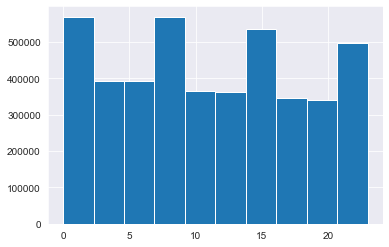

In [396]:
users_wrist_temperature.hour.hist()

In [397]:
# group by date and then take the average
users_wrist_temperature = users_wrist_temperature.groupby(['id', 'date', 'hour']).mean()
users_wrist_temperature.reset_index(drop=False, inplace=True)

In [398]:
users_wrist_temperature.head()

,id,date,hour,temperature
0,621e2e8e67b776a24055b564,2021-05-24,0,-1.466659
1,621e2e8e67b776a24055b564,2021-05-24,1,0.210289
2,621e2e8e67b776a24055b564,2021-05-24,2,-1.359378
3,621e2e8e67b776a24055b564,2021-05-24,3,-0.316295
4,621e2e8e67b776a24055b564,2021-05-24,4,0.416455


In [399]:
# merge
df = users_wrist_temperature

In [400]:
df.head()

,id,date,hour,temperature
0,621e2e8e67b776a24055b564,2021-05-24,0,-1.466659
1,621e2e8e67b776a24055b564,2021-05-24,1,0.210289
2,621e2e8e67b776a24055b564,2021-05-24,2,-1.359378
3,621e2e8e67b776a24055b564,2021-05-24,3,-0.316295
4,621e2e8e67b776a24055b564,2021-05-24,4,0.416455


In [401]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date', 'hour'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'hour', 'temperature'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


### Badge
Users get badges some days depending on their activity (N=1067). There is a variety of badges and users get them at random times, so we expect a lot of null values. To minimize the feature space we can use only the badge type, i.e., "DAILY_FLOORS", "DAILY_STEPS", "GOAL_BASED_WEIGHT_LOSS", "GOAL_BASED_WEIGHT_LOSS_ACHIEVEMENT", "LIFETIME_DISTANCE", "LIFETIME_FLOORS", "LIFETIME_WEIGHT_GOAL_SETUP".

In [402]:
users_badges = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "badge"},
            {"id": user}
        ]},
            {"id": 1, "data.dateTime": 1, "data.badgeType": 1, "_id": 0}
        )
    ))

    users_badges = pd.concat([users_badges, user_data], axis=0)

# split data column (json format) into two columns
users_badges["date"] = users_badges["data"].apply(lambda d: d["dateTime"])
users_badges["badgeType"] = users_badges["data"].apply(lambda d: d["badgeType"])
users_badges.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_badges["date"] = pd.to_datetime(users_badges["date"])
users_badges["hour"] = users_badges["date"].dt.hour
users_badges["date"] = pd.to_datetime(users_badges["date"].dt.date)

In [403]:
users_badges.head()

,id,date,badgeType,hour
0,621e2e8e67b776a24055b564,2021-07-29,DAILY_STEPS,0
1,621e2e8e67b776a24055b564,2021-07-31,DAILY_STEPS,0
2,621e2e8e67b776a24055b564,2021-05-29,DAILY_FLOORS,0
3,621e2e8e67b776a24055b564,2021-05-29,DAILY_FLOORS,0
4,621e2e8e67b776a24055b564,2021-07-31,DAILY_FLOORS,0


In [404]:
users_badges.dtypes

id                   object
date         datetime64[ns]
badgeType            object
hour                  int64
dtype: object

In [405]:
# group by ID and date to have only unique dates per participant
users_badges = users_badges.groupby(['id', 'date', 'hour']).badgeType.apply(list).reset_index(drop=False)
users_badges.badgeType = users_badges.badgeType.swifter.apply(lambda l: list(set(l)) if isinstance(l, list) else l)
users_badges.badgeType = users_badges.badgeType.swifter.apply(lambda l: np.NaN if l == [np.nan] else l)
users_badges.badgeType.value_counts()

Pandas Apply:   0%|          | 0/515 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/515 [00:00<?, ?it/s]

[LIFETIME_DISTANCE]                                                128
[DAILY_STEPS]                                                      111
[DAILY_FLOORS, DAILY_STEPS]                                         83
[LIFETIME_FLOORS]                                                   77
[DAILY_FLOORS]                                                      75
[LIFETIME_DISTANCE, LIFETIME_FLOORS]                                14
[LIFETIME_FLOORS, DAILY_STEPS]                                       7
[DAILY_FLOORS, LIFETIME_DISTANCE, DAILY_STEPS]                       4
[LIFETIME_WEIGHT_GOAL_SETUP]                                         4
[DAILY_FLOORS, LIFETIME_FLOORS, DAILY_STEPS]                         3
[DAILY_FLOORS, LIFETIME_FLOORS]                                      3
[LIFETIME_DISTANCE, DAILY_STEPS]                                     2
[DAILY_FLOORS, LIFETIME_DISTANCE, DAILY_STEPS, LIFETIME_FLOORS]      1
[DAILY_FLOORS, LIFETIME_DISTANCE]                                    1
[DAILY

In [406]:
# merge
df = df.merge(users_badges, how='outer', on=['id', 'date', 'hour'])

In [407]:
df.head(100)

,id,date,hour,temperature,badgeType
0,621e2e8e67b776a24055b564,2021-05-24,0,-1.466659,NaN
1,621e2e8e67b776a24055b564,2021-05-24,1,0.210289,NaN
2,621e2e8e67b776a24055b564,2021-05-24,2,-1.359378,NaN
3,621e2e8e67b776a24055b564,2021-05-24,3,-0.316295,NaN
4,621e2e8e67b776a24055b564,2021-05-24,4,0.416455,NaN
...,...,...,...,...,...
95,621e2e8e67b776a24055b564,2021-05-27,23,-1.128095,NaN
96,621e2e8e67b776a24055b564,2021-05-28,0,-0.492911,NaN
97,621e2e8e67b776a24055b564,2021-05-28,1,0.916755,NaN
98,621e2e8e67b776a24055b564,2021-05-28,2,-0.157328,NaN


In [408]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date', 'hour'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.astype(str).duplicated(subset=['id','date', 'hour', 'badgeType'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


### Calories
Burnt calories for the user at 3-min granularity (N=16,091,073).

In [409]:
if os.path.exists('data/users_calories_hourly.pkl'):
    print("Reading from pickle...")
    f = open("data/users_calories_hourly.pkl", "rb")
    # disable garbage collector
    gc.disable()
    # read pickle
    users_calories = pickle.load(f)
    # enable garbage collector again
    gc.enable()
    f.close()
else:
    users_calories = pd.DataFrame(columns=["id", "data"])
    for user in tqdm(users):
        user_data = pd.DataFrame(list(
            db.fitbit.find({"$and": [
                {"type": "calories"},
                {"id": user}
            ]},
                {"id": 1, "data.dateTime": 1, "data.value": 1, "_id": 0}
            )
        ))

        users_calories = pd.concat([users_calories, user_data], axis=0)

    print("Column Split...")
    # split data column (json format) into two columns
    users_calories.reset_index(drop=True, inplace=True)
    users_calories["date"] = users_calories["data"].swifter.apply(lambda d: d["dateTime"])
    users_calories["calories"] = users_calories["data"].swifter.apply(lambda d: d["value"])
    users_calories.drop(["data"], inplace=True, axis=1)
    print("Column Split Completed")
    print("Date Conversion...")
    # convert timestamp date object and then to datetime64[ns]
    # users_calories["date"] = pd.to_datetime(users_calories["date"], format="%m/%d/%y %H:%M:%S")
    users_calories["date"] = pd.to_datetime(users_calories["date"], infer_datetime_format=True)
    users_calories["hour"] = users_calories["date"].dt.hour
    users_calories["date"] = pd.to_datetime(users_calories["date"].dt.date, format="%Y/%m/%d")
    print("Date Conversion Completed")
    users_calories.to_pickle('data/users_calories_hourly.pkl')

Reading from pickle...


In [410]:
users_calories.dtypes

id                  object
date        datetime64[ns]
calories            object
hour                 int64
dtype: object

In [411]:
users_calories.head()

,id,date,calories,hour
0,621e2e8e67b776a24055b564,2021-05-24,2.62,0
1,621e2e8e67b776a24055b564,2021-05-24,1.09,0
2,621e2e8e67b776a24055b564,2021-05-24,1.09,0
3,621e2e8e67b776a24055b564,2021-05-24,1.09,0
4,621e2e8e67b776a24055b564,2021-05-24,1.09,0


In [412]:
users_calories.dtypes

id                  object
date        datetime64[ns]
calories            object
hour                 int64
dtype: object

In [413]:
# group by date and then take the average
users_calories.calories = users_calories.calories.astype(float)
users_calories = users_calories.groupby(['id', 'date', 'hour']).sum()
users_calories.reset_index(drop=False, inplace=True)

In [414]:
users_calories.head()

,id,date,hour,calories
0,621e2e8e67b776a24055b564,2021-05-24,0,89.04
1,621e2e8e67b776a24055b564,2021-05-24,1,65.62
2,621e2e8e67b776a24055b564,2021-05-24,2,65.40
3,621e2e8e67b776a24055b564,2021-05-24,3,69.01
4,621e2e8e67b776a24055b564,2021-05-24,4,65.73


In [415]:
# merge
df = df.merge(users_calories, how='outer', on=['id', 'date', 'hour'])

In [416]:
df.head()

,id,date,hour,temperature,badgeType,calories
0,621e2e8e67b776a24055b564,2021-05-24,0,-1.466659,NaN,89.04
1,621e2e8e67b776a24055b564,2021-05-24,1,0.210289,NaN,65.62
2,621e2e8e67b776a24055b564,2021-05-24,2,-1.359378,NaN,65.40
3,621e2e8e67b776a24055b564,2021-05-24,3,-0.316295,NaN,69.01
4,621e2e8e67b776a24055b564,2021-05-24,4,0.416455,NaN,65.73


In [417]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date', 'hour'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'hour', 'calories'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


### VO2 Max
VO2 Max is a measurement of how well your body uses oxygen when you’re working out at your hardest. It is widely accepted as the gold standard for grading cardiovascular fitness: the higher your VO2 Max, the more fit you are (source). This metric can also indicate performance potential for endurance-based activities including running, biking, and swimming (source).

VO2 Max is traditionally measured in a lab where you run on a treadmill or ride a stationary bike until exhaustion with a mask strapped to your nose and mouth to gauge the amount of air you inhale and exhale. While this method provides the most accurate measure of VO2 Max, your Fitbit device can estimate this value for you with less effort and discomfort.

Fitbit estimates your VO2 Max and refers to it as your cardio fitness score at a 2-day granularity (N=6364). Not applicable at hourly granularity.

### Distance
Distance walked by the user at 2-min granularity.

In [418]:
if os.path.exists('data/users_distance_hourly.pkl'):
    print("Reading from pickle...")
    f = open("data/users_distance_hourly.pkl", "rb")
    # disable garbage collector
    gc.disable()
    # read pickle
    users_distance = pickle.load(f)
    # enable garbage collector again
    gc.enable()
    f.close()
else:
    users_distance = pd.DataFrame(columns=["id", "data"])
    for user in tqdm(users):
        user_data = pd.DataFrame(list(
            db.fitbit.find({"$and": [
                {"type": "distance"},
                {"id": user}
            ]},
                {"id": 1, "data.dateTime": 1, "data.value": 1, "_id": 0}
            )
        ))

        users_distance = pd.concat([users_distance, user_data], axis=0)

    print("Column Split...")
    # split data column (json format) into two columns
    users_distance.reset_index(drop=True, inplace=True)
    users_distance["date"] = users_distance["data"].swifter.apply(lambda d: d["dateTime"])
    users_distance["distance"] = users_distance["data"].swifter.apply(lambda d: d["value"])
    users_distance.drop(["data"], inplace=True, axis=1)
    print("Column Split Completed")
    print("Date Conversion...")
    # convert timestamp date object and then to datetime64[ns]
    users_distance["date"] = pd.to_datetime(users_distance["date"], infer_datetime_format=True)
    users_distance["hour"] = users_distance["date"].dt.hour
    users_distance["date"] = pd.to_datetime(users_distance["date"].dt.date, infer_datetime_format=True)
    print("Date Conversion Completed")
    users_distance.to_pickle('data/users_distance_hourly.pkl')

Reading from pickle...


In [419]:
users_distance.dtypes

id                  object
date        datetime64[ns]
distance            object
hour                 int64
dtype: object

In [420]:
users_distance.head()

,id,date,distance,hour
0,621e2e8e67b776a24055b564,2021-05-24,880,0
1,621e2e8e67b776a24055b564,2021-05-24,0,0
2,621e2e8e67b776a24055b564,2021-05-24,660,0
3,621e2e8e67b776a24055b564,2021-05-24,0,0
4,621e2e8e67b776a24055b564,2021-05-24,0,0


In [421]:
users_distance.dtypes

id                  object
date        datetime64[ns]
distance            object
hour                 int64
dtype: object

In [422]:
# group by date and then take the average
users_distance.distance = users_distance.distance.astype(float)
users_distance = users_distance.groupby(['id', 'date', 'hour']).sum()
users_distance.reset_index(drop=False, inplace=True)
users_distance.distance = users_distance.distance / 100  # converts cm to m

<AxesSubplot:>

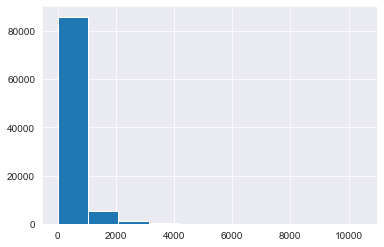

In [423]:
users_distance.distance.hist()

In [424]:
# merge
df = df.merge(users_distance, how='outer', on=['id', 'date', 'hour'])

In [425]:
df.head()

,id,date,hour,temperature,badgeType,calories,distance
0,621e2e8e67b776a24055b564,2021-05-24,0,-1.466659,NaN,89.04,98.3
1,621e2e8e67b776a24055b564,2021-05-24,1,0.210289,NaN,65.62,0.0
2,621e2e8e67b776a24055b564,2021-05-24,2,-1.359378,NaN,65.40,NaN
3,621e2e8e67b776a24055b564,2021-05-24,3,-0.316295,NaN,69.01,11.0
4,621e2e8e67b776a24055b564,2021-05-24,4,0.416455,NaN,65.73,0.0


In [426]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date', 'hour'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'hour', 'distance'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


In [427]:
df.dtypes

id                     object
date           datetime64[ns]
hour                    int64
temperature           float64
badgeType              object
calories              float64
distance              float64
dtype: object

### Exercise
The types of exercise the user has performed (N=5416). The names can be in multiple languages, hence we will use the exercise type code.

In [428]:
users_exercise = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "exercise"},
            {"id": user}
        ]},
            {"id": 1, "data.originalStartTime": 1, "data.activityTypeId": 1, "_id": 0}
        )
    ))

    users_exercise = pd.concat([users_exercise, user_data], axis=0)

# split data column (json format) into two columns
users_exercise["date"] = users_exercise["data"].apply(lambda d: d["originalStartTime"])
users_exercise["activityType"] = users_exercise["data"].apply(lambda d: d["activityTypeId"])
users_exercise.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_exercise["date"] = pd.to_datetime(users_exercise["date"], infer_datetime_format=True)
users_exercise["hour"] = users_exercise["date"].dt.hour
users_exercise["date"] = pd.to_datetime(users_exercise["date"].dt.date, infer_datetime_format=True)

In [429]:
users_exercise.head()

,id,date,activityType,hour
0,621e2e8e67b776a24055b564,2021-05-24,90013,10
1,621e2e8e67b776a24055b564,2021-05-26,90013,9
2,621e2e8e67b776a24055b564,2021-05-28,90013,10
3,621e2e8e67b776a24055b564,2021-05-29,90013,11
4,621e2e8e67b776a24055b564,2021-06-01,90013,10


In [430]:
users_exercise.dtypes

id                      object
date            datetime64[ns]
activityType             int64
hour                     int64
dtype: object

In [431]:
# Get distinct activity types
activity_types = pd.DataFrame(list(
        db.fitbit.find(
            {"type": "exercise"},
            {"id": 1, "data.activityTypeId": 1, "data.activityName": 1, "_id": 0}
        )
    ))
activity_types["activityTypeId"] = activity_types.data.apply(lambda d: d["activityTypeId"])
activity_types["activityName"] = activity_types.data.apply(lambda d: d["activityName"])
activity_types.drop(["data", "id"], inplace=True, axis=1)
activity_types = activity_types.drop_duplicates().reset_index(drop=True)
print(activity_types.head(50))
ACTIVITIES = {
    90013: "Walk",
    15000: "Sport",
    3001: "Aerobic Workout",
    52000: "Yoga/Pilates",
    90024: "Swim",
    90001: "Bike",
    20047: "Elliptical",
    2131: "Weights",
    55001: "Spinning",
    1071: "Bike",
    90009: "Run",
    20049: "Treadmill",
    53000: "Yoga/Pilates",
    55002: "Martial Arts",
    2040: "Circuit Training",
    2065: "Stairclimber",
    3000: "Workout",
    90012: "Hike",
    12339646: "Run",
    12350445: "Walk",
    23418750: "Swim",
    55003: "Bootcamp",
    15430: "Martial Arts",
    20057: "Interval Workout",
    15675: "Tennis",
    61980497: "Workout"
}

    activityTypeId      activityName
0            90013              Walk
1            15000             Sport
2             3001   Aerobic Workout
3            52000      Yoga/Pilates
4            90024              Swim
5            90001              Bike
6            55001          Spinning
7             2131           Weights
8            20047        Elliptical
9            90009               Run
10            1071              Bike
11           20049         Treadmill
12           53000      Yoga/Pilates
13           55002      Martial Arts
14            2040  Circuit Training
15            3000           Workout
16           90012              Hike
17           55003          Bootcamp
18           15430      Martial Arts
19           15675            Tennis
20           20057  Interval Workout


In [432]:
users_exercise["activityType"] = users_exercise["activityType"].apply(lambda a: ACTIVITIES.get(a))
users_exercise.head()

,id,date,activityType,hour
0,621e2e8e67b776a24055b564,2021-05-24,Walk,10
1,621e2e8e67b776a24055b564,2021-05-26,Walk,9
2,621e2e8e67b776a24055b564,2021-05-28,Walk,10
3,621e2e8e67b776a24055b564,2021-05-29,Walk,11
4,621e2e8e67b776a24055b564,2021-06-01,Walk,10


In [433]:
users_exercise = users_exercise.groupby(['id', 'date', 'hour']).activityType.apply(list).reset_index(drop=False)

In [434]:
users_exercise.activityType.value_counts()

[Walk]                              2793
[Bike]                               230
[Workout]                            157
[Sport]                              149
[Aerobic Workout]                    123
                                    ... 
[Aerobic Workout, Workout]             1
[Sport, Yoga/Pilates]                  1
[Treadmill, Workout, Elliptical]       1
[Workout, Treadmill, Elliptical]       1
[Interval Workout, Workout]            1
Name: activityType, Length: 69, dtype: int64

In [435]:
users_exercise.activityType = users_exercise.activityType.swifter.apply(lambda l: list(set(l)) if isinstance(l, list) else l)

In [436]:
users_exercise.activityType.value_counts()

[Walk]                              2793
[Bike]                               230
[Workout]                            157
[Sport]                              149
[Aerobic Workout]                    123
                                    ... 
[Aerobic Workout, Workout]             1
[Sport, Yoga/Pilates]                  1
[Treadmill, Workout, Elliptical]       1
[Workout, Treadmill, Elliptical]       1
[Interval Workout, Workout]            1
Name: activityType, Length: 69, dtype: int64

In [437]:
df.dtypes

id                     object
date           datetime64[ns]
hour                    int64
temperature           float64
badgeType              object
calories              float64
distance              float64
dtype: object

In [438]:
users_exercise.dtypes

id                      object
date            datetime64[ns]
hour                     int64
activityType            object
dtype: object

In [439]:
# merge
df = df.merge(users_exercise, how='outer', on=['id', 'date', 'hour'])

In [440]:
df.activityType.value_counts()

[Walk]                             2793
[Bike]                              230
[Workout]                           157
[Sport]                             149
[Aerobic Workout]                   123
                                   ... 
[Treadmill, Workout]                  1
[Bike, Elliptical]                    1
[Swim, Walk]                          1
[Walk, Weights]                       1
[Treadmill, Treadmill, Weights]       1
Name: activityType, Length: 69, dtype: int64

In [441]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date', 'hour'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.astype(str).duplicated(subset=['id','date', 'hour', 'activityType'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


In [442]:
df.to_pickle("data/temp_df_1_hourly.pkl")

### Heart Rate
User’s BPM at 10-sec granularity.

In [443]:
if os.path.exists('data/temp_df_1_hourly.pkl'):
    print("Reading DataFrame from pickle...")
    f = open("data/temp_df_1_hourly.pkl", "rb")
    # disable garbage collector
    gc.disable()
    # read pickle
    df = pickle.load(f)
    # enable garbage collector again
    gc.enable()
    f.close()
    print("Reading completed.")

Reading DataFrame from pickle...
Reading completed.


In [444]:
if os.path.exists('data/users_hr_hourly.pkl'):
    print("Reading hourly heart rate data from pickle...")
    f = open("data/users_hr_hourly.pkl", "rb")
    # disable garbage collector
    gc.disable()
    # read pickle
    users_hr = pickle.load(f)
    # enable garbage collector again
    gc.enable()
    f.close()
    print("Reading completed.")
else:
    warnings.warn("\nTo read and aggregate heart rate data from MongoDB you need to ensure index existence for both query (type, id) and projection (data.dateTime, data.value.bpm) fields (compound index of four fields)...\n")
    rows = 0
    users_hr = pd.DataFrame(columns=["id", "date", "bpm"])
    for user in tqdm(users):
        user_data = pd.DataFrame(list(
            db.fitbit.find({"$and": [
                {"id": user},
                {"type": "heart_rate"}
            ]},
                {"id": 1, "data.dateTime": 1, "data.value.bpm": 1, "_id": 0}
            )
        ))

        # split data column (json format) into two columns
        # user_data.reset_index(drop=True, inplace=True)
        user_data["date"] = user_data["data"].swifter.apply(lambda d: d["dateTime"])
        user_data["bpm"] = user_data["data"].swifter.apply(lambda d: d["value"].get("bpm"))
        user_data.drop(["data"], inplace=True, axis=1)
        # convert timestamp date object and then to datetime64[ns]
        # user_data["date"] = pd.to_datetime(user_data["date"], format="%Y-%m-%dT%H:%M:%S")
        user_data["date"] = pd.to_datetime(user_data["date"], infer_datetime_format=True)
        user_data['hour'] = user_data['date'].dt.hour
        user_data['date'] = pd.to_datetime(user_data['date'].dt.date, infer_datetime_format=True)

        # group by date and hour and then take the average
        user_data.bpm = user_data.bpm.astype(float)
        user_data = user_data.groupby(['id', 'date', 'hour']).mean()
        user_data.reset_index(drop=False, inplace=True)

        users_hr = pd.concat([users_hr, user_data], axis=0)

    users_hr.to_pickle('data/users_hr_hourly.pkl')
    # print("Final rows: {}".format(rows))

Reading hourly heart rate data from pickle...
Reading completed.


In [445]:
users_hr.head(20)

,id,date,bpm,hour
0,621e2e8e67b776a24055b564,2021-05-24 00:00:00,66.874763,0.0
1,621e2e8e67b776a24055b564,2021-05-24 00:00:00,58.711364,1.0
2,621e2e8e67b776a24055b564,2021-05-24 00:00:00,55.133495,2.0
3,621e2e8e67b776a24055b564,2021-05-24 00:00:00,60.488613,3.0
4,621e2e8e67b776a24055b564,2021-05-24 00:00:00,59.110638,4.0
5,621e2e8e67b776a24055b564,2021-05-24 00:00:00,57.481481,5.0
6,621e2e8e67b776a24055b564,2021-05-24 00:00:00,59.40202,6.0
7,621e2e8e67b776a24055b564,2021-05-24 00:00:00,61.217131,7.0
8,621e2e8e67b776a24055b564,2021-05-24 00:00:00,60.842478,8.0
9,621e2e8e67b776a24055b564,2021-05-24 00:00:00,73.804527,9.0


In [446]:
# convert timestamp date object and then to datetime64[ns]
users_hr["date"] = pd.to_datetime(pd.to_datetime(users_hr["date"], format="%Y/%m/%d  %H:%M:%S").dt.date, format="%Y/%m/%d")

In [447]:
users_hr.head()

,id,date,bpm,hour
0,621e2e8e67b776a24055b564,2021-05-24,66.874763,0.0
1,621e2e8e67b776a24055b564,2021-05-24,58.711364,1.0
2,621e2e8e67b776a24055b564,2021-05-24,55.133495,2.0
3,621e2e8e67b776a24055b564,2021-05-24,60.488613,3.0
4,621e2e8e67b776a24055b564,2021-05-24,59.110638,4.0


In [448]:
# merge
df = df.merge(users_hr, how='outer', on=['id', 'date', 'hour'])

In [449]:
df.head()

,id,date,hour,temperature,badgeType,calories,distance,activityType,bpm
0,621e2e8e67b776a24055b564,2021-05-24,0,-1.466659,NaN,89.04,98.3,NaN,66.874763
1,621e2e8e67b776a24055b564,2021-05-24,1,0.210289,NaN,65.62,0.0,NaN,58.711364
2,621e2e8e67b776a24055b564,2021-05-24,2,-1.359378,NaN,65.40,NaN,NaN,55.133495
3,621e2e8e67b776a24055b564,2021-05-24,3,-0.316295,NaN,69.01,11.0,NaN,60.488613
4,621e2e8e67b776a24055b564,2021-05-24,4,0.416455,NaN,65.73,0.0,NaN,59.110638


In [450]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date', 'hour'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'hour', 'bpm'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


### Lightly Active Minutes
Light activity minutes (N=12086). Not applicable at hourly granularity.

### Moderately Active Minutes
Moderate activity minutes (N=12086). Not applicable at hourly granularity.

### Very Active Minutes
Very activity minutes (N=12086). Not applicable at hourly granularity.

### Sedentary Minutes
Sedentary minutes (N=12086). Not applicable at hourly granularity.

In [451]:
df.to_pickle('data/temp_df_2_hourly.pkl')

In [452]:
df = pd.read_pickle('data/temp_df_2_hourly.pkl')

In [453]:
df.head(20)

,id,date,hour,temperature,badgeType,calories,distance,activityType,bpm
0,621e2e8e67b776a24055b564,2021-05-24,0,-1.466659,NaN,89.04,98.3,NaN,66.874763
1,621e2e8e67b776a24055b564,2021-05-24,1,0.210289,NaN,65.62,0.0,NaN,58.711364
2,621e2e8e67b776a24055b564,2021-05-24,2,-1.359378,NaN,65.40,NaN,NaN,55.133495
3,621e2e8e67b776a24055b564,2021-05-24,3,-0.316295,NaN,69.01,11.0,NaN,60.488613
4,621e2e8e67b776a24055b564,2021-05-24,4,0.416455,NaN,65.73,0.0,NaN,59.110638
5,621e2e8e67b776a24055b564,2021-05-24,5,-0.836378,NaN,65.40,NaN,NaN,57.481481
6,621e2e8e67b776a24055b564,2021-05-24,6,-0.677295,NaN,70.87,28.8,NaN,59.40202
7,621e2e8e67b776a24055b564,2021-05-24,7,0.149622,NaN,65.73,0.0,NaN,61.217131
8,621e2e8e67b776a24055b564,2021-05-24,8,0.469372,NaN,67.48,5.1,NaN,60.842478
9,621e2e8e67b776a24055b564,2021-05-24,9,-2.527628,NaN,75.61,7.3,NaN,73.804527


### Mindfulness Sessions
These data can help us understand if the user conducted an EDA session voluntarily (N=27785).

In [454]:
def try_parsing_date(text):
    for fmt in ('%Y-%m-%dT%H:%M:%S%z', '%Y-%m-%dT%H:%M%z'):
        try:
            return datetime.strptime(text, fmt)
        except ValueError:
            pass
    raise ValueError('no valid date format found for {}'.format(text))

In [455]:
users_mindfulness = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "mindfulness_sessions"},
            {"id": user}
        ]},
            {"id": 1, "data.start_date_time": 1, "data.session_type": 1, "_id": 0}
        )
    ))

    users_mindfulness = pd.concat([users_mindfulness, user_data], axis=0)

# split data column (json format) into two columns
users_mindfulness["date"] = users_mindfulness["data"].apply(lambda d: d["start_date_time"])
users_mindfulness["activityType"] = users_mindfulness["data"].apply(lambda d: d["session_type"])
users_mindfulness.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
# users_mindfulness["date"] = pd.to_datetime(users_mindfulness["date"], format='%Y-%m-%dT%H:%M:%S%z')
users_mindfulness["date"] = pd.to_datetime(users_mindfulness["date"], infer_datetime_format=True)
users_mindfulness["hour"] = users_mindfulness["date"].dt.hour
users_mindfulness["date"] = pd.to_datetime(users_mindfulness["date"].dt.date, infer_datetime_format=True)

users_mindfulness["mindfulness_session"] = True  # instead of storing the session type, only store if user engaged in session
users_mindfulness.drop(['activityType'], axis=1, inplace=True)
users_mindfulness = users_mindfulness.drop_duplicates()

In [456]:
users_mindfulness.head()

,id,date,hour,mindfulness_session
0,621e2f1b67b776a240b3d87c,2022-01-01,8,True
1,621e2f1b67b776a240b3d87c,2021-12-16,15,True
2,621e2f1b67b776a240b3d87c,2021-12-15,17,True
3,621e2f1b67b776a240b3d87c,2021-12-02,20,True
4,621e2f1b67b776a240b3d87c,2021-11-07,9,True


In [457]:
# merge
df = df.merge(users_mindfulness, how='outer', on=['id', 'date', 'hour'])
df.mindfulness_session.fillna('False', inplace=True)

In [458]:
df.head(20)

,id,date,hour,temperature,badgeType,calories,distance,activityType,bpm,mindfulness_session
0,621e2e8e67b776a24055b564,2021-05-24,0,-1.466659,NaN,89.04,98.3,NaN,66.874763,False
1,621e2e8e67b776a24055b564,2021-05-24,1,0.210289,NaN,65.62,0.0,NaN,58.711364,False
2,621e2e8e67b776a24055b564,2021-05-24,2,-1.359378,NaN,65.40,NaN,NaN,55.133495,False
3,621e2e8e67b776a24055b564,2021-05-24,3,-0.316295,NaN,69.01,11.0,NaN,60.488613,False
4,621e2e8e67b776a24055b564,2021-05-24,4,0.416455,NaN,65.73,0.0,NaN,59.110638,False
5,621e2e8e67b776a24055b564,2021-05-24,5,-0.836378,NaN,65.40,NaN,NaN,57.481481,False
6,621e2e8e67b776a24055b564,2021-05-24,6,-0.677295,NaN,70.87,28.8,NaN,59.40202,False
7,621e2e8e67b776a24055b564,2021-05-24,7,0.149622,NaN,65.73,0.0,NaN,61.217131,False
8,621e2e8e67b776a24055b564,2021-05-24,8,0.469372,NaN,67.48,5.1,NaN,60.842478,False
9,621e2e8e67b776a24055b564,2021-05-24,9,-2.527628,NaN,75.61,7.3,NaN,73.804527,False


In [459]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date', 'hour'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'hour', 'mindfulness_session'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


### Mindfulness EDA Data Sessions
These entries contain the skin conductance level, which we can get on average for a day (i.e., as an indication of stress).

In [460]:
users_eda = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "mindfulness_eda_data_sessions"},
            {"id": user}
        ]},
            {"id": 1, "data.timestamp": 1, "data.scl_avg": 1, "_id": 0}
        )
    ))

    users_eda = pd.concat([users_eda, user_data], axis=0)

# split data column (json format) into two columns
users_eda["date"] = users_eda["data"].apply(lambda d: d["timestamp"])
users_eda["scl_avg"] = users_eda["data"].apply(lambda d: d["scl_avg"])
users_eda.drop(["data"], inplace=True, axis=1)

users_eda.reset_index(drop=True, inplace=True)
# convert timestamp date object and then to datetime64[ns]
users_eda["date"] = pd.to_datetime(users_exercise["date"], infer_datetime_format=True)
users_eda["hour"] = users_eda["date"].dt.hour
users_eda["date"] = pd.to_datetime(users_eda["date"].dt.date, infer_datetime_format=True)
# users_eda["date"] = pd.to_datetime(users_eda["date"].swifter.apply(lambda ts: datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d')), format='%Y-%m-%d')

In [461]:
users_eda.head()

,id,date,scl_avg,hour
0,621e2f1b67b776a240b3d87c,2021-05-24,0.000000,0.0
1,621e2f1b67b776a240b3d87c,2021-05-24,0.000000,0.0
2,621e2f1b67b776a240b3d87c,2021-05-25,0.000000,0.0
3,621e2f1b67b776a240b3d87c,2021-05-25,35.823334,0.0
4,621e2f1b67b776a240b3d87c,2021-05-26,32.682442,0.0


In [462]:
users_eda.dtypes

id                 object
date       datetime64[ns]
scl_avg           float64
hour              float64
dtype: object

In [463]:
# group by date and then take the average
users_eda = users_eda.groupby(['id', 'date', 'hour']).mean()
users_eda.reset_index(drop=False, inplace=True)

In [464]:
users_eda.head()

,id,date,hour,scl_avg
0,621e2f1b67b776a240b3d87c,2021-05-24,0.0,3.247339
1,621e2f1b67b776a240b3d87c,2021-05-25,0.0,5.545613
2,621e2f1b67b776a240b3d87c,2021-05-26,0.0,7.463163
3,621e2f1b67b776a240b3d87c,2021-05-27,0.0,6.544056
4,621e2f1b67b776a240b3d87c,2021-05-28,0.0,5.734121


In [465]:
# merge
df = df.merge(users_eda, how='outer', on=['id', 'date', 'hour'])

In [466]:
df.head(20)

,id,date,hour,temperature,badgeType,calories,distance,activityType,bpm,mindfulness_session,scl_avg
0,621e2e8e67b776a24055b564,2021-05-24,0.0,-1.466659,NaN,89.04,98.3,NaN,66.874763,False,NaN
1,621e2e8e67b776a24055b564,2021-05-24,1.0,0.210289,NaN,65.62,0.0,NaN,58.711364,False,NaN
2,621e2e8e67b776a24055b564,2021-05-24,2.0,-1.359378,NaN,65.40,NaN,NaN,55.133495,False,NaN
3,621e2e8e67b776a24055b564,2021-05-24,3.0,-0.316295,NaN,69.01,11.0,NaN,60.488613,False,NaN
4,621e2e8e67b776a24055b564,2021-05-24,4.0,0.416455,NaN,65.73,0.0,NaN,59.110638,False,NaN
5,621e2e8e67b776a24055b564,2021-05-24,5.0,-0.836378,NaN,65.40,NaN,NaN,57.481481,False,NaN
6,621e2e8e67b776a24055b564,2021-05-24,6.0,-0.677295,NaN,70.87,28.8,NaN,59.40202,False,NaN
7,621e2e8e67b776a24055b564,2021-05-24,7.0,0.149622,NaN,65.73,0.0,NaN,61.217131,False,NaN
8,621e2e8e67b776a24055b564,2021-05-24,8.0,0.469372,NaN,67.48,5.1,NaN,60.842478,False,NaN
9,621e2e8e67b776a24055b564,2021-05-24,9.0,-2.527628,NaN,75.61,7.3,NaN,73.804527,False,NaN


In [467]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date', 'hour'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'hour', 'scl_avg'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


### Resting Heart Rate
A normal resting heart rate for adults ranges from 60 to 100 beats per minute. Generally, a lower heart rate at rest implies more efficient heart function and better cardiovascular fitness. Not applicable at hourly graularity.

### Sleep
Details about a user’s sleep IF they wore their Fitbit to bed. Not directly applicable at hourly granularity at document level (applicably to sub-document level).

### Steps
Getting steps from pre-computed file.

In [468]:
# Loading the data of daily user steps
if not os.path.exists("data/users_steps_hourly.pkl"):
    steps_dataframe = pd.DataFrame(columns=["date", "hour", "steps", "id"])
    for user in tqdm(users):
        user_dataframe = pd.DataFrame(list(
            db.fitbit.find(
                {"type": "steps",
                 "id": user},
                {"data.dateTime": 1, "data.value": 1, "id": 1, "_id": 0}
            )
        ))
        user_dataframe['date'] = user_dataframe['data'].swifter.progress_bar(False).apply(lambda d: d['dateTime'])
        user_dataframe['steps'] = user_dataframe['data'].swifter.progress_bar(False).apply(lambda d: d['value'])
        user_dataframe.drop(["data"], inplace=True, axis=1)

        # basic preprocessing for steps - transformations
        user_dataframe['steps'] = pd.to_numeric(user_dataframe['steps'])  # was string
        user_dataframe["date"] = pd.to_datetime(user_dataframe["date"], infer_datetime_format=True)
        user_dataframe["hour"] = user_dataframe["date"].dt.hour
        user_dataframe["date"] = pd.to_datetime(user_dataframe["date"].dt.date, infer_datetime_format=True)

        steps_dataframe = pd.concat([steps_dataframe, user_dataframe], axis=0, ignore_index=True)

    # group by date and then take the sum
    steps_dataframe = steps_dataframe.groupby(['id', 'date', 'hour']).sum()
    steps_dataframe.reset_index(drop=False, inplace=True)
    steps_dataframe.to_pickle("data/users_steps_hourly.pkl")

infile = open('data/users_steps_hourly.pkl','rb')
steps_daily = pickle.load(infile)
infile.close()
# steps_daily = steps_daily[["date", "steps", "id"]]
steps_daily # year-month-day e.g. 2021-05-24

,id,date,hour,steps
0,621e2e8e67b776a24055b564,2021-05-24,0,134
1,621e2e8e67b776a24055b564,2021-05-24,1,0
2,621e2e8e67b776a24055b564,2021-05-24,3,15
3,621e2e8e67b776a24055b564,2021-05-24,4,0
4,621e2e8e67b776a24055b564,2021-05-24,6,39
...,...,...,...,...
93089,621e375b67b776a240290cdc,2021-08-01,20,243
93090,621e375b67b776a240290cdc,2021-08-01,21,704
93091,621e375b67b776a240290cdc,2021-08-01,22,436
93092,621e375b67b776a240290cdc,2021-08-01,23,205


In [469]:
# merge
df = df.merge(steps_daily, how='outer', on=['id', 'date', 'hour'])

In [470]:
df.head(20)

,id,date,hour,temperature,badgeType,calories,distance,activityType,bpm,mindfulness_session,scl_avg,steps
0,621e2e8e67b776a24055b564,2021-05-24,0.0,-1.466659,NaN,89.04,98.3,NaN,66.874763,False,NaN,134.0
1,621e2e8e67b776a24055b564,2021-05-24,1.0,0.210289,NaN,65.62,0.0,NaN,58.711364,False,NaN,0.0
2,621e2e8e67b776a24055b564,2021-05-24,2.0,-1.359378,NaN,65.40,NaN,NaN,55.133495,False,NaN,NaN
3,621e2e8e67b776a24055b564,2021-05-24,3.0,-0.316295,NaN,69.01,11.0,NaN,60.488613,False,NaN,15.0
4,621e2e8e67b776a24055b564,2021-05-24,4.0,0.416455,NaN,65.73,0.0,NaN,59.110638,False,NaN,0.0
5,621e2e8e67b776a24055b564,2021-05-24,5.0,-0.836378,NaN,65.40,NaN,NaN,57.481481,False,NaN,NaN
6,621e2e8e67b776a24055b564,2021-05-24,6.0,-0.677295,NaN,70.87,28.8,NaN,59.40202,False,NaN,39.0
7,621e2e8e67b776a24055b564,2021-05-24,7.0,0.149622,NaN,65.73,0.0,NaN,61.217131,False,NaN,0.0
8,621e2e8e67b776a24055b564,2021-05-24,8.0,0.469372,NaN,67.48,5.1,NaN,60.842478,False,NaN,7.0
9,621e2e8e67b776a24055b564,2021-05-24,9.0,-2.527628,NaN,75.61,7.3,NaN,73.804527,False,NaN,10.0


In [471]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date', 'hour'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'hour', 'steps'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


In [472]:
# print("Size before duplicate elimination: {}".format(df.shape[0]))
# df = df.groupby(["id", "date", 'hour']).first()
# df.reset_index(drop=False, inplace=True)
# print("Size after duplicate elimination: {}".format(df.shape[0]))

<AxesSubplot:>

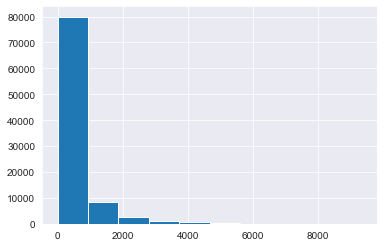

In [473]:
df.steps.hist()

### Time in Heart Rate Zones
Minutes below zone, and in zones 1, 2, and 3.

In [474]:
users_time_in_heart_rate_zones = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "time_in_heart_rate_zones"},
            {"id": user}
        ]},
            {"id": 1, "data.dateTime": 1, "data.value": 1, "_id": 0}
        )
    ))

    users_time_in_heart_rate_zones = pd.concat([users_time_in_heart_rate_zones, user_data], axis=0)

# split data column (json format) into two columns
users_time_in_heart_rate_zones["date"] = users_time_in_heart_rate_zones["data"].apply(lambda d: d["dateTime"])
users_time_in_heart_rate_zones["minutes_in_default_zone_1"] = users_time_in_heart_rate_zones["data"].apply(lambda d: d["value"].get("valuesInZones").get("IN_DEFAULT_ZONE_1"))
users_time_in_heart_rate_zones["minutes_below_default_zone_1"] = users_time_in_heart_rate_zones["data"].apply(lambda d: d["value"].get("valuesInZones").get("BELOW_DEFAULT_ZONE_1"))
users_time_in_heart_rate_zones["minutes_in_default_zone_2"] = users_time_in_heart_rate_zones["data"].apply(lambda d: d["value"].get("valuesInZones").get("IN_DEFAULT_ZONE_2"))
users_time_in_heart_rate_zones["minutes_in_default_zone_3"] = users_time_in_heart_rate_zones["data"].apply(lambda d: d["value"].get("valuesInZones").get("IN_DEFAULT_ZONE_3"))
users_time_in_heart_rate_zones.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_time_in_heart_rate_zones["date"] = pd.to_datetime(users_time_in_heart_rate_zones["date"], format="%m/%d/%y %H:%M:%S")
users_time_in_heart_rate_zones["hour"] = users_time_in_heart_rate_zones["date"].dt.hour
users_time_in_heart_rate_zones["date"] = pd.to_datetime(users_time_in_heart_rate_zones["date"].dt.date, infer_datetime_format=True)

In [475]:
users_time_in_heart_rate_zones.head(20)

,id,date,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,hour
0,621e2e8e67b776a24055b564,2021-05-26,85.0,1350.0,0.0,0.0,0
1,621e2e8e67b776a24055b564,2021-05-30,20.0,1160.0,0.0,0.0,0
2,621e2e8e67b776a24055b564,2021-06-03,68.0,1368.0,0.0,0.0,0
3,621e2e8e67b776a24055b564,2021-06-07,61.0,1366.0,0.0,0.0,0
4,621e2e8e67b776a24055b564,2021-06-11,95.0,1289.0,0.0,0.0,0
5,621e2e8e67b776a24055b564,2021-06-15,53.0,1377.0,5.0,0.0,0
6,621e2e8e67b776a24055b564,2021-06-19,116.0,1301.0,0.0,0.0,0
7,621e2e8e67b776a24055b564,2021-06-23,67.0,1361.0,0.0,0.0,0
8,621e2e8e67b776a24055b564,2021-06-27,47.0,1386.0,0.0,0.0,0
9,621e2e8e67b776a24055b564,2021-07-01,42.0,1390.0,2.0,0.0,0


In [476]:
# merge
df = df.merge(users_time_in_heart_rate_zones, how='outer', on=['id', 'date', 'hour'])

In [477]:
df.head(20)

,id,date,hour,temperature,badgeType,calories,distance,activityType,bpm,mindfulness_session,scl_avg,steps,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3
0,621e2e8e67b776a24055b564,2021-05-24,0.0,-1.466659,NaN,89.04,98.3,NaN,66.874763,False,NaN,134.0,83.0,1349.0,0.0,0.0
1,621e2e8e67b776a24055b564,2021-05-24,1.0,0.210289,NaN,65.62,0.0,NaN,58.711364,False,NaN,0.0,NaN,NaN,NaN,NaN
2,621e2e8e67b776a24055b564,2021-05-24,2.0,-1.359378,NaN,65.40,NaN,NaN,55.133495,False,NaN,NaN,NaN,NaN,NaN,NaN
3,621e2e8e67b776a24055b564,2021-05-24,3.0,-0.316295,NaN,69.01,11.0,NaN,60.488613,False,NaN,15.0,NaN,NaN,NaN,NaN
4,621e2e8e67b776a24055b564,2021-05-24,4.0,0.416455,NaN,65.73,0.0,NaN,59.110638,False,NaN,0.0,NaN,NaN,NaN,NaN
5,621e2e8e67b776a24055b564,2021-05-24,5.0,-0.836378,NaN,65.40,NaN,NaN,57.481481,False,NaN,NaN,NaN,NaN,NaN,NaN
6,621e2e8e67b776a24055b564,2021-05-24,6.0,-0.677295,NaN,70.87,28.8,NaN,59.40202,False,NaN,39.0,NaN,NaN,NaN,NaN
7,621e2e8e67b776a24055b564,2021-05-24,7.0,0.149622,NaN,65.73,0.0,NaN,61.217131,False,NaN,0.0,NaN,NaN,NaN,NaN
8,621e2e8e67b776a24055b564,2021-05-24,8.0,0.469372,NaN,67.48,5.1,NaN,60.842478,False,NaN,7.0,NaN,NaN,NaN,NaN
9,621e2e8e67b776a24055b564,2021-05-24,9.0,-2.527628,NaN,75.61,7.3,NaN,73.804527,False,NaN,10.0,NaN,NaN,NaN,NaN


In [478]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date', 'hour'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'hour', 'minutes_below_default_zone_1'], keep=False)].shape[0]))

Duplicates based on ID and Date: 136
Duplicates based on ID and Date and Value: 134


<AxesSubplot:>

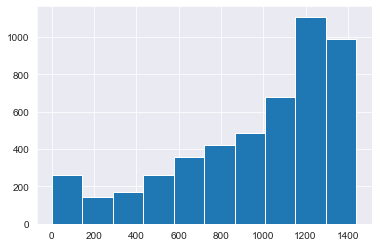

In [479]:
df['minutes_below_default_zone_1'].hist()

<AxesSubplot:>

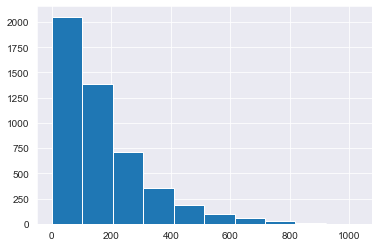

In [480]:
df['minutes_in_default_zone_1'].hist()

<AxesSubplot:>

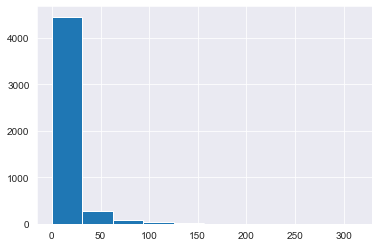

In [481]:
df['minutes_in_default_zone_2'].hist()

<AxesSubplot:>

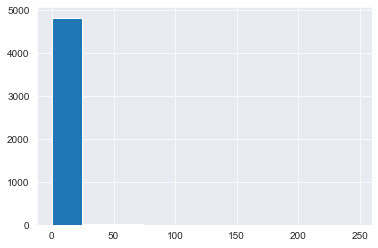

In [482]:
df['minutes_in_default_zone_3'].hist()

### Profile
Demographic Information about the user (N=70).

In [483]:
def get_age(date_of_birth):
    today = date.today()
    return today.year - date_of_birth.year - ((today.month, today.day) < (date_of_birth.month, date_of_birth.day))

In [484]:
users_profiles = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "Profile"},
            {"id": user}
        ]},
            # {"id": 1, "data.date_of_birth": 1, "data.gender": 1, "data.height": 1, "data.weight": 1,  "_id": 0}
            {"id": 1, "data.age": 1, "data.gender": 1, "data.bmi": 1,  "_id": 0}
        )
    ))

    users_profiles = pd.concat([users_profiles, user_data], axis=0)

# users_profiles["age"] = users_profiles["data"].apply(lambda d: d["date_of_birth"])
# users_profiles["age"] = pd.to_datetime(users_profiles["age"], format="%Y/%m/%d")
# users_profiles["age"] = users_profiles["age"].apply(lambda d: get_age(d))
# users_profiles["height"] = users_profiles["data"].apply(lambda d: d["height"])
# users_profiles["weight"] = users_profiles["data"].apply(lambda d: d["weight"])
# users_profiles["gender"] = users_profiles["data"].apply(lambda d: d["gender"])


users_profiles["age"] = users_profiles["data"].apply(lambda d: d["age"] if "age" in d else np.NaN)
users_profiles["gender"] = users_profiles["data"].apply(lambda d: d["gender"] if "gender" in d else np.NaN)
users_profiles["bmi"] = users_profiles["data"].apply(lambda d: d["bmi"] if "bmi" in d else np.NaN)

users_profiles.drop(['data'], axis=1, inplace=True)
users_profiles.head(70)

,id,age,gender,bmi
0,621e2e8e67b776a24055b564,<30,MALE,<19
0,621e2eaf67b776a2406b14ac,>=30,FEMALE,<19
0,621e2ed667b776a24085d8d1,<30,FEMALE,23.0
0,621e2ef567b776a24099f889,<30,MALE,28.0
0,621e2efa67b776a2409dd1c3,<30,FEMALE,21.0
...,...,...,...,...
0,621e36c267b776a240ba2756,<30,MALE,20.0
0,621e36dd67b776a240ce9a45,>=30,MALE,24.0
0,621e36f967b776a240e5e7c9,<30,FEMALE,>=25
0,621e375367b776a24021e950,<30,MALE,28.0


In [485]:
# merge
df = df.merge(users_profiles, how='left', on=['id'])

In [486]:
df.head(100)

,id,date,hour,temperature,badgeType,calories,distance,activityType,bpm,mindfulness_session,scl_avg,steps,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,age,gender,bmi
0,621e2e8e67b776a24055b564,2021-05-24,0.0,-1.466659,NaN,89.04,98.3,NaN,66.874763,False,NaN,134.0,83.0,1349.0,0.0,0.0,<30,MALE,<19
1,621e2e8e67b776a24055b564,2021-05-24,1.0,0.210289,NaN,65.62,0.0,NaN,58.711364,False,NaN,0.0,NaN,NaN,NaN,NaN,<30,MALE,<19
2,621e2e8e67b776a24055b564,2021-05-24,2.0,-1.359378,NaN,65.40,NaN,NaN,55.133495,False,NaN,NaN,NaN,NaN,NaN,NaN,<30,MALE,<19
3,621e2e8e67b776a24055b564,2021-05-24,3.0,-0.316295,NaN,69.01,11.0,NaN,60.488613,False,NaN,15.0,NaN,NaN,NaN,NaN,<30,MALE,<19
4,621e2e8e67b776a24055b564,2021-05-24,4.0,0.416455,NaN,65.73,0.0,NaN,59.110638,False,NaN,0.0,NaN,NaN,NaN,NaN,<30,MALE,<19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,621e2e8e67b776a24055b564,2021-05-27,23.0,-1.128095,NaN,67.26,5.9,NaN,65.607143,False,NaN,8.0,NaN,NaN,NaN,NaN,<30,MALE,<19
96,621e2e8e67b776a24055b564,2021-05-28,0.0,-0.492911,NaN,65.73,0.0,NaN,59.741525,False,NaN,0.0,146.0,1274.0,4.0,0.0,<30,MALE,<19
97,621e2e8e67b776a24055b564,2021-05-28,1.0,0.916755,NaN,65.62,0.0,NaN,65.536364,False,NaN,0.0,NaN,NaN,NaN,NaN,<30,MALE,<19
98,621e2e8e67b776a24055b564,2021-05-28,2.0,-0.157328,NaN,65.84,0.0,NaN,55.979499,False,NaN,0.0,NaN,NaN,NaN,NaN,<30,MALE,<19


### Saving to pickle file

In [487]:
df.to_pickle('./data/hourly_fitbit_df_unprocessed.pkl')

In [488]:
df = pd.read_pickle('./data/hourly_fitbit_df_unprocessed.pkl')

In [489]:
df.dtypes

id                                      object
date                            datetime64[ns]
hour                                   float64
temperature                            float64
badgeType                               object
calories                               float64
distance                               float64
activityType                            object
bpm                                     object
mindfulness_session                     object
scl_avg                                float64
steps                                  float64
minutes_in_default_zone_1              float64
minutes_below_default_zone_1           float64
minutes_in_default_zone_2              float64
minutes_in_default_zone_3              float64
age                                     object
gender                                  object
bmi                                     object
dtype: object

## Integrating SEMA Data
The SEMA ecological ecological momentary assessment surveys include data about the users' daily step goals (maximum once per day) as well as emotions and locations (maximum three times a day)

### Integrating step goals
This field includes the user's daily step goal range (N=1921).

In [490]:
# user goals in SEMA
SEMA_GOALS_TO_MIN = {
    "2000": 0,
    "4999": 2000,
    "7999": 5000,
    "9999": 8000,
    "14999": 10000,
    "19999": 15000,
    "24999": 20000,
    "25000": 25000,
    "NO_GOAL": 0
}

SEMA_GOALS_TO_MAX = {
    "2000": 2000,
    "4999": 5000,
    "7999": 8000,
    "9999": 10000,
    "14999": 15000,
    "19999": 20000,
    "24999": 25000,
    "25000": 30000,
    "NO_GOAL": 0
}

SEMA_LABELS = {
    "2000": "Less than 2000",
    "4999": "2000-4999",
    "7999": "5000-7999",
    "9999": "8000-9999",
    "14999": "10000-14999",
    "19999": "15000-19999",
    "24999": "20000-24999",
    "25000": "More than 25000",
    "NO_GOAL": "No Goal",
    np.nan: "No Goal",
    None: "No Goal"
}

In [491]:
if not os.path.exists("data/users_step_goals_hourly.pkl"):
    # Get user self-reported goals from SEMA
    sema_goals = pd.DataFrame(columns=["_id", "user_id", "data"])
    for user in users:
        user_data = pd.DataFrame(list(
                        db.sema.find({ "$and": [
                            { "data.STEPS": { "$ne": "<no-response>" } },
                            {"user_id": user}
                        ] },
                            {"data.STEPS": 1, "id": 1, "user_id": 1, "data.STARTED_TS": 1}
                        )
                    ))

        sema_goals = pd.concat([sema_goals, user_data], axis=0)

    # split data column (json format) into two columns
    sema_goals["timestamp"] = sema_goals["data"].apply(lambda d: d["STARTED_TS"])
    sema_goals["step_goal"] = sema_goals["data"].apply(lambda d: d["STEPS"])
    sema_goals.drop(["data", "_id"], inplace=True, axis=1)

    # convert timestamp to day format
    sema_goals["date"] = pd.to_datetime(sema_goals["timestamp"], infer_datetime_format=True)
    sema_goals["hour"] = sema_goals["date"].dt.hour
    sema_goals["date"] = pd.to_datetime(sema_goals["date"].dt.date, infer_datetime_format=True) # convert from object to datetime
    sema_goals.drop(["timestamp"], inplace=True, axis=1)

    # add min goal and max goal columns
    sema_goals['min_goal'] = sema_goals.step_goal.apply(lambda s: SEMA_GOALS_TO_MIN.get(s))
    sema_goals['max_goal'] = sema_goals.step_goal.apply(lambda s: SEMA_GOALS_TO_MAX.get(s))

    # add goal labels
    sema_goals['step_goal_label'] = sema_goals['step_goal'].apply(lambda v: SEMA_LABELS[v])
    sema_goals[['date', 'hour', 'user_id', 'step_goal', 'min_goal', 'max_goal', 'step_goal_label']].to_pickle('./data/users_step_goals_hourly.pkl')

users_step_goals = pd.read_pickle('./data/users_step_goals_hourly.pkl')
users_step_goals['id'] = users_step_goals.user_id.copy()
users_step_goals.drop(['user_id'], axis=1, inplace=True)

In [492]:
users_step_goals.head(10)

,date,hour,step_goal,min_goal,max_goal,step_goal_label,id
0,2021-07-18,11,7999,5000.0,8000.0,5000-7999,621e2e8e67b776a24055b564
1,2021-06-27,15,7999,5000.0,8000.0,5000-7999,621e2e8e67b776a24055b564
2,2021-07-23,12,14999,10000.0,15000.0,10000-14999,621e2e8e67b776a24055b564
3,2021-06-03,13,9999,8000.0,10000.0,8000-9999,621e2e8e67b776a24055b564
4,2021-07-14,13,9999,8000.0,10000.0,8000-9999,621e2e8e67b776a24055b564
5,2021-06-18,13,9999,8000.0,10000.0,8000-9999,621e2e8e67b776a24055b564
6,2021-06-20,15,7999,5000.0,8000.0,5000-7999,621e2e8e67b776a24055b564
7,2021-07-21,13,9999,8000.0,10000.0,8000-9999,621e2e8e67b776a24055b564
8,2021-05-25,14,14999,10000.0,15000.0,10000-14999,621e2e8e67b776a24055b564
9,2021-07-24,15,9999,8000.0,10000.0,8000-9999,621e2e8e67b776a24055b564


In [493]:
# merge
df = df.merge(users_step_goals, how='outer', on=['id', 'date', 'hour'])

In [494]:
df.head(50)

,id,date,hour,temperature,badgeType,calories,distance,activityType,bpm,mindfulness_session,...,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,age,gender,bmi,step_goal,min_goal,max_goal,step_goal_label
0,621e2e8e67b776a24055b564,2021-05-24,0.0,-1.466659,NaN,89.04,98.3,NaN,66.874763,False,...,1349.0,0.0,0.0,<30,MALE,<19,NaN,NaN,NaN,NaN
1,621e2e8e67b776a24055b564,2021-05-24,1.0,0.210289,NaN,65.62,0.0,NaN,58.711364,False,...,NaN,NaN,NaN,<30,MALE,<19,NaN,NaN,NaN,NaN
2,621e2e8e67b776a24055b564,2021-05-24,2.0,-1.359378,NaN,65.40,NaN,NaN,55.133495,False,...,NaN,NaN,NaN,<30,MALE,<19,NaN,NaN,NaN,NaN
3,621e2e8e67b776a24055b564,2021-05-24,3.0,-0.316295,NaN,69.01,11.0,NaN,60.488613,False,...,NaN,NaN,NaN,<30,MALE,<19,NaN,NaN,NaN,NaN
4,621e2e8e67b776a24055b564,2021-05-24,4.0,0.416455,NaN,65.73,0.0,NaN,59.110638,False,...,NaN,NaN,NaN,<30,MALE,<19,NaN,NaN,NaN,NaN
5,621e2e8e67b776a24055b564,2021-05-24,5.0,-0.836378,NaN,65.40,NaN,NaN,57.481481,False,...,NaN,NaN,NaN,<30,MALE,<19,NaN,NaN,NaN,NaN
6,621e2e8e67b776a24055b564,2021-05-24,6.0,-0.677295,NaN,70.87,28.8,NaN,59.40202,False,...,NaN,NaN,NaN,<30,MALE,<19,NaN,NaN,NaN,NaN
7,621e2e8e67b776a24055b564,2021-05-24,7.0,0.149622,NaN,65.73,0.0,NaN,61.217131,False,...,NaN,NaN,NaN,<30,MALE,<19,NaN,NaN,NaN,NaN
8,621e2e8e67b776a24055b564,2021-05-24,8.0,0.469372,NaN,67.48,5.1,NaN,60.842478,False,...,NaN,NaN,NaN,<30,MALE,<19,NaN,NaN,NaN,NaN
9,621e2e8e67b776a24055b564,2021-05-24,9.0,-2.527628,NaN,75.61,7.3,NaN,73.804527,False,...,NaN,NaN,NaN,<30,MALE,<19,NaN,NaN,NaN,NaN


In [495]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date', 'hour'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'hour', 'step_goal_label'], keep=False)].shape[0]))

Duplicates based on ID and Date: 140
Duplicates based on ID and Date and Value: 140


In [496]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
no_dups = df.astype(str).drop_duplicates()
no_dups[no_dups.astype(str).duplicated(keep = False, subset=['id','date', 'hour'])]

,id,date,hour,temperature,badgeType,calories,distance,activityType,bpm,mindfulness_session,...,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,age,gender,bmi,step_goal,min_goal,max_goal,step_goal_label
19315,621e301e67b776a240608a72,2021-08-28,0.0,0.06868898333333334,nan,154.84,88.7,nan,96.2668416447944,False,...,154.0,65.0,0.0,<30,FEMALE,19.0,nan,nan,nan,nan
19316,621e301e67b776a240608a72,2021-08-28,0.0,0.06868898333333334,nan,154.84,88.7,nan,96.2668416447944,False,...,219.0,100.0,0.0,<30,FEMALE,19.0,nan,nan,nan,nan


In [497]:
df.dtypes

id                                      object
date                            datetime64[ns]
hour                                   float64
temperature                            float64
badgeType                               object
calories                               float64
distance                               float64
activityType                            object
bpm                                     object
mindfulness_session                     object
scl_avg                                float64
steps                                  float64
minutes_in_default_zone_1              float64
minutes_below_default_zone_1           float64
minutes_in_default_zone_2              float64
minutes_in_default_zone_3              float64
age                                     object
gender                                  object
bmi                                     object
step_goal                               object
min_goal                               float64
max_goal     

### Integrating Εmotions & Location

In [498]:
# read data
if not os.path.exists('./data/sema_mood_place_hourly.pkl'):
    # Get user self-reported goals from SEMA
    users = db.sema.distinct('user_id')

    sema_mood = pd.DataFrame(columns=["_id", "user_id", "data"])
    for user in users:
        user_data = pd.DataFrame(list(
                        db.sema.find({
                            "$or": [
                                {
                                    "$and": [
                                        { "data.MOOD": { "$ne": "<no-response>" } },
                                        {"data.MOOD": { "$ne": None }},
                                        {"user_id": user}
                                    ]
                                },
                                {
                                    "$and": [
                                        { "data.PLACE": { "$ne": "<no-response>" } },
                                        {"data.PLACE": { "$ne": None }},
                                        {"user_id": user}
                                    ]
                                }
                            ]
                        },
                            {"data.MOOD": 1, "data.PLACE": 1, "id": 1, "_id": 0, "user_id": 1, "data.STARTED_TS": 1}
                        )
                    ))

        sema_mood = pd.concat([sema_mood, user_data], axis=0)

    sema_mood["date"] = pd.to_datetime(sema_mood["data"].apply(lambda d: d["STARTED_TS"]), infer_datetime_format=True)
    sema_mood["hour"] = sema_mood["date"].dt.hour
    sema_mood["date"] = pd.to_datetime(sema_mood["date"].dt.date, infer_datetime_format=True)
    sema_mood["data.MOOD"] = sema_mood["data"].apply(lambda d: d["MOOD"])
    sema_mood["data.PLACE"] = sema_mood["data"].apply(lambda d: d["PLACE"])
    sema_mood.drop(["_id", "data"], axis=1, inplace=True)
    sema_mood.to_pickle('./data/sema_mood_place_hourly.pkl')
else:
    sema_mood = pd.read_pickle('./data/sema_mood_place_hourly.pkl')
print(sema_mood.head())

                    user_id       date  hour data.MOOD   data.PLACE
0  621e2e8e67b776a24055b564 2021-06-10    16   NEUTRAL  WORK/SCHOOL
1  621e2e8e67b776a24055b564 2021-06-13    14   NEUTRAL         HOME
2  621e2e8e67b776a24055b564 2021-07-24    15     HAPPY     OUTDOORS
3  621e2e8e67b776a24055b564 2021-06-01    10     HAPPY     OUTDOORS
4  621e2e8e67b776a24055b564 2021-06-21    18     TIRED     OUTDOORS


In [499]:
infile = open('./data/sema_mood_place_hourly.pkl','rb')
sema = pickle.load(infile)
infile.close()

sema.head() # year-month-day e.g. 2021-05-24

,user_id,date,hour,data.MOOD,data.PLACE
0,621e2e8e67b776a24055b564,2021-06-10,16,NEUTRAL,WORK/SCHOOL
1,621e2e8e67b776a24055b564,2021-06-13,14,NEUTRAL,HOME
2,621e2e8e67b776a24055b564,2021-07-24,15,HAPPY,OUTDOORS
3,621e2e8e67b776a24055b564,2021-06-01,10,HAPPY,OUTDOORS
4,621e2e8e67b776a24055b564,2021-06-21,18,TIRED,OUTDOORS


In [500]:
# process dateTime to date
# sema['date'] = pd.to_datetime(sema['Dates'])
# sema.drop(['data.CREATED_TS', 'Dates'], axis=1, inplace=True)

# replace not common moods
sema['data.MOOD'] = sema['data.MOOD'].apply(lambda mood: 'SAD' if mood == 'SADNESS' else ('HAPPY' if mood == 'JOY' else mood))
sema = sema[(sema['data.MOOD'] != 'FEAR') & (sema['data.MOOD'] != 'SURPRISE') & (sema['data.MOOD'] != 'ANGER') & (sema['data.MOOD'] != '<no-response>')]
print(sema['data.MOOD'].value_counts())
print(sema['data.PLACE'].value_counts())

sema.head()

RESTED/RELAXED    1179
TIRED             1126
NEUTRAL            822
HAPPY              790
TENSE/ANXIOUS      620
ALERT              345
SAD                149
Name: data.MOOD, dtype: int64
HOME             2960
WORK/SCHOOL       869
OUTDOORS          381
HOME_OFFICE       309
TRANSIT           224
ENTERTAINMENT     209
OTHER              60
GYM                18
Name: data.PLACE, dtype: int64


,user_id,date,hour,data.MOOD,data.PLACE
0,621e2e8e67b776a24055b564,2021-06-10,16,NEUTRAL,WORK/SCHOOL
1,621e2e8e67b776a24055b564,2021-06-13,14,NEUTRAL,HOME
2,621e2e8e67b776a24055b564,2021-07-24,15,HAPPY,OUTDOORS
3,621e2e8e67b776a24055b564,2021-06-01,10,HAPPY,OUTDOORS
4,621e2e8e67b776a24055b564,2021-06-21,18,TIRED,OUTDOORS


In [501]:
sema_moods = pd.get_dummies(sema['data.MOOD'])
sema_places = pd.get_dummies(sema['data.PLACE'])
print(sema_moods.head())
print(sema_places.head())

   ALERT  HAPPY  NEUTRAL  RESTED/RELAXED  SAD  TENSE/ANXIOUS  TIRED
0      0      0        1               0    0              0      0
1      0      0        1               0    0              0      0
2      0      1        0               0    0              0      0
3      0      1        0               0    0              0      0
4      0      0        0               0    0              0      1
   ENTERTAINMENT  GYM  HOME  HOME_OFFICE  OTHER  OUTDOORS  TRANSIT  \
0              0    0     0            0      0         0        0   
1              0    0     1            0      0         0        0   
2              0    0     0            0      0         1        0   
3              0    0     0            0      0         1        0   
4              0    0     0            0      0         1        0   

   WORK/SCHOOL  
0            1  
1            0  
2            0  
3            0  
4            0  


In [502]:
# combine one-hot encoding with actual df
sema = pd.concat([sema, sema_moods, sema_places], axis=1)
sema.drop(['data.MOOD', 'data.PLACE'], axis=1, inplace=True)
sema.head(50)

,user_id,date,hour,ALERT,HAPPY,NEUTRAL,RESTED/RELAXED,SAD,TENSE/ANXIOUS,TIRED,ENTERTAINMENT,GYM,HOME,HOME_OFFICE,OTHER,OUTDOORS,TRANSIT,WORK/SCHOOL
0,621e2e8e67b776a24055b564,2021-06-10,16,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,621e2e8e67b776a24055b564,2021-06-13,14,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,621e2e8e67b776a24055b564,2021-07-24,15,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,621e2e8e67b776a24055b564,2021-06-01,10,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,621e2e8e67b776a24055b564,2021-06-21,18,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
5,621e2e8e67b776a24055b564,2021-05-27,11,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
6,621e2e8e67b776a24055b564,2021-06-15,19,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
7,621e2e8e67b776a24055b564,2021-07-22,10,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
8,621e2e8e67b776a24055b564,2021-06-02,12,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
9,621e2e8e67b776a24055b564,2021-06-17,10,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [503]:
sema_grouped = sema.groupby(['date', 'hour', 'user_id']).max()
sema_grouped.reset_index(drop=False, inplace=True)
sema_grouped['id'] = sema_grouped['user_id'].copy()
sema_grouped.drop(['user_id'], axis=1, inplace=True)
sema_grouped.reset_index(drop=True, inplace=True)
sema_grouped.id = sema_grouped.id.swifter.apply(lambda id: ObjectId(id))
sema_grouped.head()

Pandas Apply:   0%|          | 0/5029 [00:00<?, ?it/s]

,date,hour,ALERT,HAPPY,NEUTRAL,RESTED/RELAXED,SAD,TENSE/ANXIOUS,TIRED,ENTERTAINMENT,GYM,HOME,HOME_OFFICE,OTHER,OUTDOORS,TRANSIT,WORK/SCHOOL,id
0,2021-04-22,20,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,621e362467b776a2404ad513
1,2021-04-23,10,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,621e362467b776a2404ad513
2,2021-04-23,15,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,621e362467b776a2404ad513
3,2021-04-24,23,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,621e362467b776a2404ad513
4,2021-04-25,19,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,621e362467b776a2404ad513


(array([18748., 18779., 18809., 18840., 18871., 18901., 18932., 18962.,
        18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

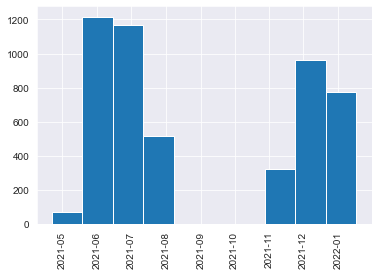

In [504]:
sema_grouped.date.hist()
plt.xticks(rotation=90)

In [505]:
# merge
df = df.merge(sema_grouped, how='outer', on=['id', 'date', 'hour'])

In [506]:
df.head(50)

,id,date,hour,temperature,badgeType,calories,distance,activityType,bpm,mindfulness_session,...,TENSE/ANXIOUS,TIRED,ENTERTAINMENT,GYM,HOME,HOME_OFFICE,OTHER,OUTDOORS,TRANSIT,WORK/SCHOOL
0,621e2e8e67b776a24055b564,2021-05-24,0.0,-1.466659,NaN,89.04,98.3,NaN,66.874763,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,621e2e8e67b776a24055b564,2021-05-24,1.0,0.210289,NaN,65.62,0.0,NaN,58.711364,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,621e2e8e67b776a24055b564,2021-05-24,2.0,-1.359378,NaN,65.40,NaN,NaN,55.133495,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,621e2e8e67b776a24055b564,2021-05-24,3.0,-0.316295,NaN,69.01,11.0,NaN,60.488613,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,621e2e8e67b776a24055b564,2021-05-24,4.0,0.416455,NaN,65.73,0.0,NaN,59.110638,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,621e2e8e67b776a24055b564,2021-05-24,5.0,-0.836378,NaN,65.40,NaN,NaN,57.481481,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,621e2e8e67b776a24055b564,2021-05-24,6.0,-0.677295,NaN,70.87,28.8,NaN,59.40202,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,621e2e8e67b776a24055b564,2021-05-24,7.0,0.149622,NaN,65.73,0.0,NaN,61.217131,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,621e2e8e67b776a24055b564,2021-05-24,8.0,0.469372,NaN,67.48,5.1,NaN,60.842478,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,621e2e8e67b776a24055b564,2021-05-24,9.0,-2.527628,NaN,75.61,7.3,NaN,73.804527,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [507]:
df.to_pickle('./data/hourly_fitbit_sema_df_unprocessed.pkl')

In [508]:
# df.to_csv('./data/daily_fitbit_sema_df_unprocessed.csv')

In [509]:
df = pd.read_pickle('./data/hourly_fitbit_sema_df_unprocessed.pkl')

In [510]:
df.head(50)

,id,date,hour,temperature,badgeType,calories,distance,activityType,bpm,mindfulness_session,...,TENSE/ANXIOUS,TIRED,ENTERTAINMENT,GYM,HOME,HOME_OFFICE,OTHER,OUTDOORS,TRANSIT,WORK/SCHOOL
0,621e2e8e67b776a24055b564,2021-05-24,0.0,-1.466659,NaN,89.04,98.3,NaN,66.874763,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,621e2e8e67b776a24055b564,2021-05-24,1.0,0.210289,NaN,65.62,0.0,NaN,58.711364,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,621e2e8e67b776a24055b564,2021-05-24,2.0,-1.359378,NaN,65.40,NaN,NaN,55.133495,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,621e2e8e67b776a24055b564,2021-05-24,3.0,-0.316295,NaN,69.01,11.0,NaN,60.488613,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,621e2e8e67b776a24055b564,2021-05-24,4.0,0.416455,NaN,65.73,0.0,NaN,59.110638,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,621e2e8e67b776a24055b564,2021-05-24,5.0,-0.836378,NaN,65.40,NaN,NaN,57.481481,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,621e2e8e67b776a24055b564,2021-05-24,6.0,-0.677295,NaN,70.87,28.8,NaN,59.40202,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,621e2e8e67b776a24055b564,2021-05-24,7.0,0.149622,NaN,65.73,0.0,NaN,61.217131,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,621e2e8e67b776a24055b564,2021-05-24,8.0,0.469372,NaN,67.48,5.1,NaN,60.842478,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,621e2e8e67b776a24055b564,2021-05-24,9.0,-2.527628,NaN,75.61,7.3,NaN,73.804527,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [511]:
df.to_csv('./data/hourly_fitbit_sema_df_unprocessed.csv')